<a href="https://colab.research.google.com/github/gongx030/Etv2_pioneer/blob/master/2e_NOME_Enriched_Heatmap_with_MNase_and_Etv2_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook examines the MEF MNase-seq signal at the Etv2 binding sites at MEF D1 post Etv2 induction.  The anaysis shows that Etv2 binds both NFR and NOR regions
by Nikita Dsouza



In [1]:
start_time0 <- Sys.time()
options(max.print=1000)

### Install external packages

In [2]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libgsl23 libgslcblas0"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html"                                                           

In [3]:
system('apt-get install libcairo2-dev', intern = TRUE) # for Cairo package that is required by ComplexHeatmap package

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  libcairo2-doc"                                                                                                       

## Install R packages

In [4]:
install.packages('BiocManager', version = 3.12)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
required_packages <- c(
  'devtools',
  'GenomicRanges', 'rtracklayer', 
  'BSgenome.Mmusculus.UCSC.mm10',
  'EnrichedHeatmap',  'circlize'
)

In [6]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.2 (2021-11-01)

Installing package(s) 'BiocVersion', 'GenomicRanges', 'rtracklayer',
  'BSgenome.Mmusculus.UCSC.mm10', 'EnrichedHeatmap', 'circlize'

also installing the dependencies ‘formatR’, ‘lambda.r’, ‘futile.options’, ‘futile.logger’, ‘snow’, ‘BH’, ‘MatrixGenerics’, ‘Biobase’, ‘DelayedArray’, ‘iterators’, ‘GenomeInfoDbData’, ‘bitops’, ‘BiocParallel’, ‘Rhtslib’, ‘SummarizedExperiment’, ‘rjson’, ‘clue’, ‘png’, ‘foreach’, ‘doParallel’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘GenomeInfoDb’, ‘XVector’, ‘XML’, ‘Biostrings’, ‘zlibbioc’, ‘RCurl’, ‘Rsamtools’, ‘GenomicAlignments’, ‘BiocIO’, ‘restfulr’, ‘BSgenome’, ‘ComplexHeatmap’, ‘matrixStats’, ‘GetoptLong’, ‘locfit’, ‘GlobalOptions’, ‘shape’


Old packages: 'backports', 'brio', 'cpp11', 'credentials', 'devtools',
  'diges

## Load R packages

In [7]:
library(GenomicRanges)
library(dplyr)
library(BSgenome.Mmusculus.UCSC.mm10)
library(SummarizedExperiment)
library(ggplot2)
library(EnrichedHeatmap)
library(circlize) # colorRamp2
library(devtools)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb


Attaching package: ‘dplyr’


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union

## Read the Etv2 ChIP-seq peaks at D1 MEF reprogramming

In [8]:
all_etv2_peaks_url <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/all_Etv2_peaks.rds'
gr <- readRDS(gzcon(url(all_etv2_peaks_url)))
gr
colnames(gr$group)

GRanges object with 162010 ranges and 4 metadata columns:
           seqnames            ranges strand |                peak_id     score
              <Rle>         <IRanges>  <Rle> |            <character> <numeric>
       [1]     chr1   3037784-3037983      * | /panfs/roc/scratch/g..  16.22768
       [2]     chr1   3263790-3263989      * | /panfs/roc/scratch/g..   8.36521
       [3]     chr1   3344682-3344881      * | /panfs/roc/scratch/g..   9.73217
       [4]     chr1   3460640-3460839      * | /panfs/roc/scratch/g..   3.92081
       [5]     chr1   3490314-3490513      * | /panfs/roc/scratch/g..  12.29730
       ...      ...               ...    ... .                    ...       ...
  [162006]     chrY 90828936-90829135      * | /panfs/roc/scratch/g.. 160.15463
  [162007]     chrY 90836259-90836458      * | /panfs/roc/scratch/g..   8.27339
  [162008]     chrY 90841624-90841823      * | /panfs/roc/scratch/g..   1.53792
  [162009]     chrY 90842563-90842762      * | /panfs/roc/scra

[1] "MEF_Dox_d1_Etv2" "MEF_Dox_d2_Etv2" "MEF_Dox_d7_Etv2" "EB_Dox_3h_Etv2" 
[5] "EB_Dox_12h_Etv2"

In [9]:
peaks <- gr[gr$group[, 'MEF_Dox_d1_Etv2']]
seqlevels(peaks) <- seqlevels(BSgenome.Mmusculus.UCSC.mm10)
seqlengths(peaks) <- seqlengths(BSgenome.Mmusculus.UCSC.mm10)
seqinfo(peaks) <- seqinfo(BSgenome.Mmusculus.UCSC.mm10)
peaks

GRanges object with 123337 ranges and 4 metadata columns:
           seqnames            ranges strand |                peak_id     score
              <Rle>         <IRanges>  <Rle> |            <character> <numeric>
       [1]     chr1   3037784-3037983      * | /panfs/roc/scratch/g..  16.22768
       [2]     chr1   3490314-3490513      * | /panfs/roc/scratch/g..  12.29730
       [3]     chr1   3531626-3531825      * | /panfs/roc/scratch/g..  16.22768
       [4]     chr1   3671125-3671324      * | /panfs/roc/scratch/g..   6.73792
       [5]     chr1   3671746-3671945      * | /panfs/roc/scratch/g..   9.54304
       ...      ...               ...    ... .                    ...       ...
  [123333]     chrY 90828479-90828678      * | /panfs/roc/scratch/g..  20.49355
  [123334]     chrY 90828936-90829135      * | /panfs/roc/scratch/g.. 160.15463
  [123335]     chrY 90841624-90841823      * | /panfs/roc/scratch/g..   1.53792
  [123336]     chrY 90842563-90842762      * | /panfs/roc/scra

## Download related `pileup` and `fold enrichment` bigwig files

`rtracklayer::import` does not support importing bigwig files with URL starting with 'https://'. We need to download the bigwig files first.

In [10]:
bw_files <- c('MEF_Dox_D1_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Etv2_FE.bw',
	'MNase' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/MNase_treat_pileup.bw')

In [11]:
for (i in 1:length(bw_files)){
  sprintf('wget -x -c -nH %s', bw_files[i]) %>% system()
}
local_bw_files <- gsub('https://s3.msi.umn.edu/', './', bw_files)

In [12]:
message(sprintf('all local_bw_files exist: %s', all(file.exists(local_bw_files))))

all local_bw_files exist: TRUE



## Prepare normalized matrix for MNase-seq and Etv2 ChIP-seq data for `EnrichedHeatmap`

In [13]:
sprintf('number of Etv2 peaks in MEFS: %d', length(peaks)) %>% message()

number of Etv2 peaks in MEFS: 123337



In [14]:
extend <- 1000
w <- 50
smooth <- FALSE
target_ratio <- 0.2
target_width <- width(peaks)[1]
message(sprintf('target width: %d\n', target_width))

target width: 200




In [15]:
mat <- lapply(local_bw_files, function(bw_file){
  cvg <- rtracklayer::import(
    bw_file, 
    which = trim(GenomicRanges::reduce(resize(peaks, fix = 'center', width = target_width + extend * 2)))
  )  # returned as a GRanges object
  normalizeToMatrix(
    cvg, 
    resize(peaks, fix = 'center', width = 1), 
    extend = extend, 
    value_column = 'score', 
    mean_mode = 'w0', 
    w = w, 
    smooth = smooth, 
    target_ratio = target_ratio
  )
})

Warning message in .normarg_seqnames2(seqnames, seqinfo):
“levels in 'seqnames' with no entries in 'seqinfo' were dropped”
Warning message in .normarg_seqnames2(seqnames, seqinfo):
“levels in 'seqnames' with no entries in 'seqinfo' were dropped”


### Getting the cluster information from MNase seq data as done previously by Dr. Wuming

In [16]:
i <- seq_len(length(peaks))
mean_mnase <- rowMeans(mat[['MNase']][, (extend / w - 1):(extend / w  + 1)])
cls <- as.numeric(cut(mean_mnase, quantile(mean_mnase, c(1, 0.75, 0.25, 0)), include.lowest = TRUE))
sp <- factor(cls)


In [17]:
peaks$sp <- sp

## Process the GC percent using the bed files

In [18]:
bed <- c('D0_Pos' = 'https://s3.msi.umn.edu/dsouz072/datasets/dataset=NOMeseq_MEF_version=20210923a/D0_NOME.bed',
         'D1_Pos' = 'https://s3.msi.umn.edu/dsouz072/datasets/dataset=NOMeseq_MEF_version=20210923a/D1_NOME.bed'
         )

In [19]:
for (i in 1:length(bed)){
  sprintf('wget -x -c -nH %s', bed[i]) %>% system()
}
bed <- gsub('https://s3.msi.umn.edu/', './', bed)
message(sprintf('all local_bw_files exist: %s', all(file.exists(bed))))

all local_bw_files exist: TRUE



In [20]:
tab <- lapply(bed, function(b){read.table(b, sep = '\t')})
GCH <- lapply(tab, function(t){GRanges(t$V1, IRanges(t$V2, width=1))})
GCH <- lapply(GCH, function(g){
  seqlengths(g) <- seqlengths(Mmusculus)[seqlevels(g)]
  return(g)})
GCH <- lapply(1:length(GCH), function(g){
  values(GCH[[g]]) <- as.data.frame(tab[[g]])[,-c(1:3)]
  return(GCH[[g]])
})

In [21]:
names(GCH) <- names(tab)
GCH <- lapply(names(GCH), function(g){
          colnames(mcols(GCH[[g]])) <- c(sprintf('%s.C',g),sprintf('%s.cov',g))
          return(GCH[[g]])
})
names(GCH) <- names(tab)

In [22]:
GCH_percent <- GCH

Changing the score to 1-GpC methylation percent 

In [23]:
GCH_percent[[1]]$D0_Pos.C <- 100*(1- GCH_percent[[1]]$D0_Pos.C)

In [24]:
GCH_percent[[2]]$D1_Pos.C <- 100*(1- GCH_percent[[2]]$D1_Pos.C)

Changing the score to 1-GpC methylation

In [25]:
GCH[[1]]$D0_Pos.C <- (1- GCH[[1]]$D0_Pos.C)

In [26]:
GCH[[2]]$D1_Pos.C <- (1- GCH[[2]]$D1_Pos.C)

# Normalized matrix calculation for Day 0 and Day 1 NOMeseq

In [27]:
mat_d0_percent <-  normalizeToMatrix(
    resize(GCH_percent[[1]], width = 200, fix = 'center'), 
    resize(peaks, fix = 'center', width = 1), 
    extend = extend, 
    value_column = 'D0_Pos.C', 
    mean_mode = 'w0', 
    w = w, 
    smooth = smooth, 
    target_ratio = target_ratio
  )

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 11 out-of-bound ranges located on sequence
  chrM. Note that ranges located on a sequence whose length is unknown
  (NA) or on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information.”


In [28]:
mat_d0 <-  normalizeToMatrix(
    resize(GCH[[1]], width = 200, fix = 'center'), 
    resize(peaks, fix = 'center', width = 1), 
    extend = extend, 
    value_column = 'D0_Pos.C', 
    mean_mode = 'w0', 
    w = w, 
    smooth = smooth, 
    target_ratio = target_ratio
  )

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 11 out-of-bound ranges located on sequence
  chrM. Note that ranges located on a sequence whose length is unknown
  (NA) or on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information.”


In [29]:
mat_d1_percent <-  normalizeToMatrix(
    resize(GCH_percent[[2]], width = 200, fix = 'center'), 
    resize(peaks, fix = 'center', width = 1), 
    extend = extend, 
    value_column = 'D1_Pos.C', 
    mean_mode = 'w0', 
    w = w, 
    smooth = smooth, 
    target_ratio = target_ratio
  )

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 11 out-of-bound ranges located on sequence
  chrM. Note that ranges located on a sequence whose length is unknown
  (NA) or on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information.”


In [30]:
mat_d1 <-  normalizeToMatrix(
    resize(GCH[[2]], width = 200, fix = 'center'), 
    resize(peaks, fix = 'center', width = 1), 
    extend = extend, 
    value_column = 'D1_Pos.C', 
    mean_mode = 'w0', 
    w = w, 
    smooth = smooth, 
    target_ratio = target_ratio
  )

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 11 out-of-bound ranges located on sequence
  chrM. Note that ranges located on a sequence whose length is unknown
  (NA) or on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information.”


In [31]:
length(which(rowSums(mat_d0_percent) > 0))

[1] 91391

In [32]:
r <- which(rowSums(mat_d0_percent) > 0) #Removing rows with all zeroes in matrix for D0

#Subsetting normalized matrix to exclude rows that are all 0 in D0 NOMe-seq 

In [33]:
mat_d0_percent_sub <- mat_d0_percent[r,]
mat_d1_percent_sub <- mat_d1_percent[r,]
mat_d0_sub <- mat_d0[r,]
mat_d1_sub <- mat_d1[r,]
mat_sub <- mat[['MNase']][r,]
mat_etv2 <- mat[['MEF_Dox_D1_Etv2']][r,]

## Splitting regions into different clusters based on the mean of center 150 bp region


In [34]:
i <- seq_len(length(peaks))
mean_d0 <- rowMeans(mat_d0_percent_sub[, (extend / w - 1):(extend / w  + 1)])
cls_d0 <- as.numeric(cut(mean_d0, quantile(mean_d0, c(1, 0.55, 0)), include.lowest = TRUE))
sp_d0 <- factor(cls_d0)

In [35]:
message(sprintf('The number of peaks that are nucleosome occupied in Day 0 NOMe-seq: %s', length(sp_d0[sp_d0 == 2])))

The number of peaks that are nucleosome occupied in Day 0 NOMe-seq: 41126



# Subsetting the normalized matrix to include nucleosome occupied regions in day 0

In [36]:
mat_d0_nor <- mat_d0_sub[sp_d0 == 2,]
mat_d1_nor <- mat_d1_sub[sp_d0 == 2,]
mat_sub_nor <- mat_sub[sp_d0 == 2,]
mat_etv2_nor <- mat_etv2[sp_d0 == 2,]

#Testing the significance of the ~41000 peaks in Day 0 NOMe-seq to obtain Nucleosome regions changing to Nucleosome depleted regions in Day 1

Subsetting ETV2 ChIP-seq peaks to the 41126 regions

In [37]:
peaks_sub <- peaks[r,]

In [38]:
peaks_sub$sp <- sp_d0

In [39]:
peaks_nor <- peaks_sub[sp_d0 ==2,]

In [40]:
peaks_nor

GRanges object with 41126 ranges and 5 metadata columns:
          seqnames            ranges strand |                peak_id     score
             <Rle>         <IRanges>  <Rle> |            <character> <numeric>
      [1]     chr1   3490314-3490513      * | /panfs/roc/scratch/g..  12.29730
      [2]     chr1   3531626-3531825      * | /panfs/roc/scratch/g..  16.22768
      [3]     chr1   3671125-3671324      * | /panfs/roc/scratch/g..   6.73792
      [4]     chr1   3754485-3754684      * | /panfs/roc/scratch/g..   4.97274
      [5]     chr1   4090307-4090506      * | /panfs/roc/scratch/g..   8.57992
      ...      ...               ...    ... .                    ...       ...
  [41122]     chrY 90800337-90800536      * | /panfs/roc/scratch/g..   69.3242
  [41123]     chrY 90807354-90807553      * | /panfs/roc/scratch/g..  103.2391
  [41124]     chrY 90811392-90811591      * | /panfs/roc/scratch/g..   74.1391
  [41125]     chrY 90812310-90812509      * | /panfs/roc/scratch/g..   42.

# Calculating the number of methylated cytosine multiplying the coverage information and percent of accessibilty 

In [41]:
center_width <- 200L

In [42]:
GCH[[1]]$D0_Pos.nC <- round(GCH[[1]]$D0_Pos.cov * GCH[[1]]$D0_Pos.C)
GCH[[2]]$D1_Pos.nC <- round(GCH[[2]]$D1_Pos.cov * GCH[[2]]$D1_Pos.C)

## Calculating the coverage extending the region to 2000kb 


In [43]:
GCH_cov <- list()
GCH_cov[[1]] <- GCH[[1]] %>% coverage(weight = 'D0_Pos.cov')
GCH_cov[[2]] <- GCH[[2]] %>% coverage(weight = 'D1_Pos.cov')
GCH_C <- list()
GCH_C[[1]] <- GCH[[1]] %>% coverage(weight = 'D0_Pos.nC')
GCH_C[[2]] <- GCH[[2]] %>% coverage(weight = 'D1_Pos.nC')

## Defining a 200 bp sliding windows with 20 bp steps

In [44]:
wins <- peaks_nor %>% 
  resize(fix = 'center', width = 2000L) %>% 
  slidingWindows(width = center_width, step = 20L) %>%
  unlist()

In [45]:
GCH_win_conv <- lapply(GCH_cov, function(cov) cov[wins] %>% sum())
GCH_win_C <- lapply(GCH_C, function(cov) cov[wins] %>% sum())

In [46]:
p_C <- sum(GCH_win_C[[2]]) / sum(GCH_win_conv[[2]])

In [47]:
centers <- peaks_nor %>%
  resize(fix = 'center', width = center_width)

In [48]:
GCH_win_conv_centers <- lapply(GCH_cov, function(cov) cov[centers] %>% sum())
GCH_win_C_centers <- lapply(GCH_C, function(cov) cov[centers] %>% sum())

In [49]:
x <- lapply(1:2, function(i) cbind(C = GCH_win_C_centers[[i]], not_C = GCH_win_conv_centers[[i]] - GCH_win_C_centers[[i]]))
x <- rbind(data.frame(x[[1]], group = 'D0'), data.frame(x[[2]], group = 'D1'))

# P-values obtained using test of equal or given proportions to find nucleosome occupied region that are significant 

In [50]:
set.seed(1234)
not_zeros <- x[, 'C'] > 0
pvalue <- rep(1, nrow(x))
pvalue[not_zeros] <- sapply(which(not_zeros), function(i) suppressWarnings(prop.test(x[i, 'C'], n = x[i, 'C'] + x[i, 'not_C'], p = p_C, alternative = 'greater')$p.value))

In [51]:
x <- cbind(x, pvalue = pvalue)

In [52]:
x %>% group_by(group) %>% summarize(n = sum(pvalue < 0.05, na.rm = TRUE))

group,n
<chr>,<int>
D0,5320
D1,2481


# Subsetting the number of peaks to the 5320 Nucleosome occupied peaks in Day 0 that are significant

In [53]:
x_D0 <- x %>% filter(group == 'D0')

In [54]:
p_D0 <- (which(x_D0$pvalue < 0.05))

In [55]:
message(sprintf('The number of peaks that are nucleosome occupied and significant in Day 0 NOMe-seq: %s', length(p_D0)))

The number of peaks that are nucleosome occupied and significant in Day 0 NOMe-seq: 5320



## Subsetting normalized matrix to include 5320 rows that are significant

In [56]:
mat_sig_d0 <- mat_d0_nor[p_D0,]
mat_sig_d1 <- mat_d1_nor[p_D0,]
mat_sig_mnase <- mat_sub_nor[p_D0,]
mat_sig_etv2 <- mat_etv2_nor[p_D0,]

In [57]:
xx <- matrix(x$pvalue, nrow(x) / 2, 2)

# The number of Nucleosome depleted regions and Nucleosome occupied regions in D1 NOMe-seq

In [58]:
message(sprintf('The number of peaks that are nucleosome occupied and significant in Day 0 and nucleosome depleted in Day 1 NOMe-seq: %s', sum(xx[, 1] < 0.05 & xx[, 2] > 0.05, na.rm = TRUE)))

The number of peaks that are nucleosome occupied and significant in Day 0 and nucleosome depleted in Day 1 NOMe-seq: 4744



In [59]:
message(sprintf('The number of peaks that are nucleosome occupied and significant in Day 0 and nucleosome occupied in Day 1 NOMe-seq: %s', sum(xx[, 1] < 0.05 & xx[, 2] < 0.05, na.rm = TRUE)))

The number of peaks that are nucleosome occupied and significant in Day 0 and nucleosome occupied in Day 1 NOMe-seq: 576



# Splitting the 5320 peaks into 2 groups Nucleosome occupied regions and Nucleosome depleted regions

In [60]:
dat_xx <- data.frame(xx)

In [61]:
dat_xx$sp <- ifelse(xx[, 1] < 0.05 & xx[, 2] > 0.05, 'NDR', 'NOR')

In [62]:
clus <- dat_xx$sp[p_D0] #NOR and NDR groups used for the enriched heatmap

In [63]:
clus <- factor(clus)

In [64]:
sig_d0 <- which(xx[, 1] < 0.05 & xx[, 2] > 0.05)

# Enriched Heatmap

# Color annotation

In [65]:
col_fun_d0 <- colorRamp2(quantile(mat_sig_d0, c(0.01, 0.99)), c('white', 'brown'))
col_fun_d1 <- colorRamp2(quantile(mat_sig_d1, c(0.01, 0.99)), c('white', 'brown'))
col_fun_mn <- colorRamp2(quantile(mat_sig_mnase, c(0.01, 0.99)), c('white', 'navyblue'))
col_fun_etv2 <- colorRamp2(quantile(mat_sig_etv2, c(0.01, 0.99)), c('white', 'red'))

## Top annotation for the line plot

In [66]:
ta <- HeatmapAnnotation(
  enriched = anno_enriched(gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(clus))
  #axis_param = list(facing = 'inside', at = -1000)
#ylim = c(-0.5,2)
  )
)

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FA

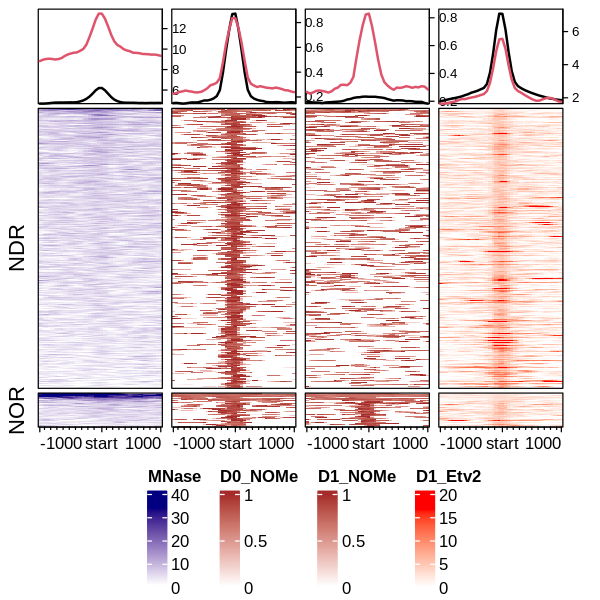

In [67]:
h <-  EnrichedHeatmap(mat_sig_mnase, col = col_fun_mn, name = 'MNase', top_annotation = ta, pos_line = FALSE) +
      EnrichedHeatmap(mat_sig_d0, col = col_fun_d0, name = 'D0_NOMe', top_annotation = ta, pos_line = FALSE) +
      EnrichedHeatmap(mat_sig_d1, col = col_fun_d1, name = 'D1_NOMe', top_annotation = ta, pos_line = FALSE) +
      EnrichedHeatmap(mat_sig_etv2, col = col_fun_etv2, name = 'D1_Etv2', top_annotation = ta, pos_line = FALSE) 


options(repr.plot.width = 5, repr.plot.height = 5)
draw(h, heatmap_legend_side = 'bottom', split = clus )

In [68]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] devtools_2.4.2                     usethis_2.1.3                     
 [3] circlize_0.4.13                    EnrichedHeatmap_1.24.0            
 [5] ComplexHeatmap_2.10.0              ggplot2_3.3.5                     
 [7] SummarizedExperi

In [69]:
Sys.time() - start_time0

Time difference of 37.54176 mins